# 서울특별시 다산콜센터(☎120)의 주요 민원
* 서울특별시 다산콜센터(☎120)의 주요 민원(자주 묻는 질문)에 대한 답변정보
* https://opengov.seoul.go.kr/civilappeal/list

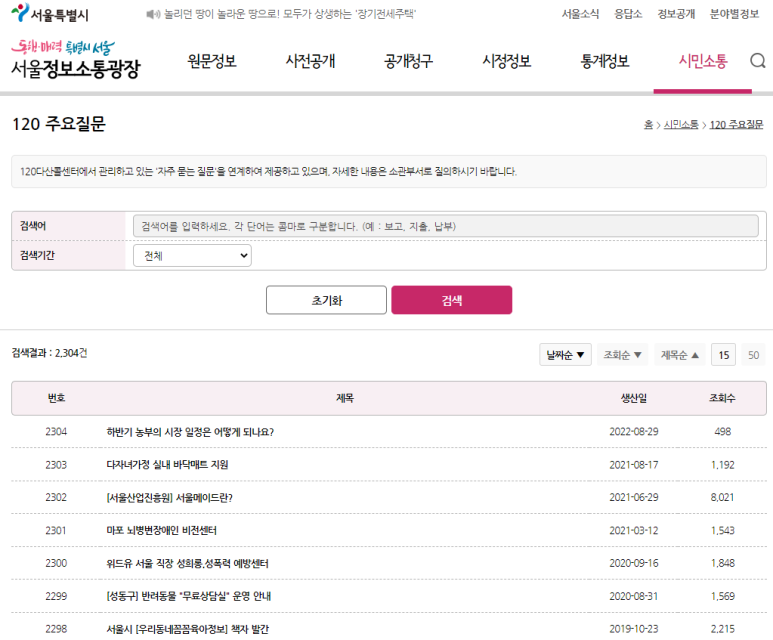

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup as bs
import time

In [2]:
def get_one_page(page_no):
    """
    120 주요질문의 특정 페이지 목록을 수집
    1) page_no 마다 url이 변경되게 f-string 을 사용해 만든다.
    2) requests 를 사용해서 요청을 보내고 응답을 받는다.
    3) pd.read_html 을 사용해서 table tag로 게시물을 읽어온다.
    4) 3번 결과에서 0번 인덱스를 가져와 데이터프레임으로 목록의 내용을 만든다.
    5) html tag를 parsing할 수 있게 bs 형태로 만든다.
    6) 목록 안에 있는 a tag를 찾는다.
    7) a tag 안에서 string 을 분리해서 내용번호만 리스트 형태로 만든다.
    8) 4)의 결과에 "내용번호"라는 컬럼을 만들고 a tag의 리스트를 추가한다.
    """

    base_url = f"https://opengov.seoul.go.kr/civilappeal/list?items_per_page=50&page={page_no}"

    response = requests.get(base_url)

    table = pd.read_html(base_url, encoding="utf-8")[0]
    if table.shape[0] == 0:
        return f"{page_no} 페이지를 찾을 수 없습니다."        

    html = bs(response.text)

    a_list = html.select('td.data-title.aLeft > a')

    a_link_no = []
    for a_tag in a_list:
        a_link_no.append(a_tag["href"].split("/")[-1])

    table["내용번호"] = a_link_no

    return table

In [3]:
# 함수가 잘 동작하는지 확인
get_one_page(1).head()

,번호,제목,생산일,조회수,내용번호
0,2304,하반기 농부의 시장 일정은 어떻게 되나요?,2022-08-29,512,26695536
1,2303,다자녀가정 실내 바닥매트 지원,2021-08-17,1199,25670204
2,2302,[서울산업진흥원] 서울메이드란?,2021-06-29,8041,23194045
3,2301,마포 뇌병변장애인 비전센터,2021-03-12,1551,22477798
4,2300,위드유 서울 직장 성희롱.성폭력 예방센터,2020-09-16,1854,21212235


In [4]:
# 없는 페이지도 확인
get_one_page(49)

'49 페이지를 찾을 수 없습니다.'

In [5]:
# 게시물이 없으면 멈춥니다.
def get_all_page():
    page_no = 1
    table_list = []

    while True:
        df_temp = get_one_page(page_no)
        if type(df_temp) == str: #페이지를 찾을 수 없습니다. 로 나옴
            break;
        table_list.append(df_temp)
        page_no = page_no + 1
        time.sleep(0.1)
    
    df = pd.concat(table_list)
    return df

In [6]:
df = get_all_page()

In [7]:
df = df.head(10) #너무 양이 많아서 줄였음

In [8]:
def get_desc(response):
    """
    분류 수집 및 테이블 보기 좋게 정돈하기
    전치행렬 transpose() == T 를 하기 위해 인덱스를 설정해 주었습니다.
    전치행렬을 했을 때 index <=> columns 위치가 변경되기 때문에 인덱스로 설정해 주었습니다.
    """

    table = pd.read_html(response.text)[-1]
    tb01 = table[[0, 1]].set_index(0).T
    tb02 = table[[2, 3]].set_index(2).T
    tb02.index = tb01.index
    df_desc = pd.concat([tb01, tb02], axis="columns")

    return df_desc

In [9]:
# 잘 작동하는지 확인
url = "https://opengov.seoul.go.kr/civilappeal/view/?nid=23194045"

response = requests.get(url)

get_desc(response)

,원본시스템,작성자(책임자),관리번호,제공부서,생산일,분류
1,다산콜센터,120다산콜재단,D0000042894548,서울산업진흥원,2021-06-29,경제


In [10]:
def get_view_page(view_no):
    """ 
    내용과 분류를 수집하는 함수 만들기
    1) url을 만들어 줍니다.
    2) requests 로 요청을 보냅니다.
    3) 분류와 제공부서 등이 들어있는 데이터프레임을 얻습니다.
    4) 내용을 bs 으로 텍스트만 추출합니다.
    5) 3)번 내용에 내용, 내용번호를 함께 데이터프레임에 추가합니다.
    6) 반복문 대신 map이나 apply를 사용할 것이기 때문에 time.sleep으로 쉬도록 합니다.
    7) 5번까지 수집한 내용을 반환하도록 합니다.
    """

    url = f"https://opengov.seoul.go.kr/civilappeal/view/?nid={view_no}"

    response = requests.get(url)
    df_desc = get_desc(response)

    html = bs(response.text)
    content = html.select("div.view-content.view-content-article > div > div.line-all")[0].text
    df_desc["내용"] = content
    df_desc["내용번호"] = view_no

    return df_desc

In [11]:
get_view_page(23194045)

,원본시스템,작성자(책임자),관리번호,제공부서,생산일,분류,내용,내용번호
1,다산콜센터,120다산콜재단,D0000042894548,서울산업진흥원,2021-06-29,경제,\n 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해 만들어진 라이프스타일...,23194045


In [12]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from tqdm.notebook import tqdm
tqdm.pandas()

view_detail = df["내용번호"].progress_map(get_view_page)

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
view_detail[1]

,원본시스템,작성자(책임자),관리번호,제공부서,생산일,분류,내용,내용번호
1,다산콜센터,120다산콜재단,D0000043274644,서울특별시 서초구 주민생활국 여성보육과,2021-08-17,복지,\n 업무개요 다자녀가정 아이들의 안전한 실내 활동과 층간소음 예방을 ...,25670204


In [15]:
df_view = pd.concat(view_detail.tolist())

In [16]:
# 기존 데이터와 병합하여 내용이 함께 수집된 것을 확인합니다.
df_detail = df.merge(df_view, on=["내용번호", "생산일"])
df_detail

,번호,제목,생산일,조회수,내용번호,원본시스템,작성자(책임자),관리번호,제공부서,분류,내용
0,2304,하반기 농부의 시장 일정은 어떻게 되나요?,2022-08-29,512,26695536,다산콜센터,120다산콜재단,D0000046114132,대외협력과,경제,\n ○ 하반기 운영일정 구 분 일 정 9월 10월 1...
1,2303,다자녀가정 실내 바닥매트 지원,2021-08-17,1199,25670204,다산콜센터,120다산콜재단,D0000043274644,서울특별시 서초구 주민생활국 여성보육과,복지,\n 업무개요 다자녀가정 아이들의 안전한 실내 활동과 층간소음 예방을 ...
2,2302,[서울산업진흥원] 서울메이드란?,2021-06-29,8041,23194045,다산콜센터,120다산콜재단,D0000042894548,서울산업진흥원,경제,\n 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해 만들어진 라이프스타일...
3,2301,마포 뇌병변장애인 비전센터,2021-03-12,1551,22477798,다산콜센터,120다산콜재단,D0000042114742,서울특별시 복지정책실 복지기획관 장애인복지정책과,복지,\n ▣ 마포뇌병변장애인 비전센터 운영 구분 내용 목적 학령기 이...
4,2300,위드유 서울 직장 성희롱.성폭력 예방센터,2020-09-16,1854,21212235,다산콜센터,120다산콜재단,D0000040829456,서울특별시 여성가족정책실 여성권익담당관,복지,\n 업무개요 직장 내 성희롱 지원체계 사각지대에 있는 서울 시민이 안전하...
5,2299,"[성동구] 반려동물 ""무료상담실"" 운영 안내",2020-08-31,1574,21095911,다산콜센터,120다산콜재단,D0000040706778,서울특별시 자치구,경제,"\n▣ 반려동물 무료상담실_""무엇이든 물어보시개?"" 운영 안내 구분 내용 ..."
6,2298,서울시 [우리동네꼼꼼육아정보] 책자 발간,2019-10-23,2219,18955676,다산콜센터,120다산콜재단,D0000038442669,서울특별시 여성가족정책실 아이돌봄담당관,복지,\n서울시와 서울시육아종합지원센터는 140여 명의 우리동네 보육반장이 직접 발로 뛰...
7,2297,"[종료사업] S-Taxi 앱 (에스택시, 서울택시승차앱) 시범운영",2019-06-03,2268,17949033,다산콜센터,120다산콜재단,D0000036784830,서울특별시 도시교통실 교통기획관 택시물류과,교통,\r\n\t\t\t\t\t\t\t업무개요\n\n '빈차를 보고 택시를 이용' 하는 ...
8,2296,장기요양 이동지원서비스(모두타 돌봄택시),2019-05-27,3039,17896364,다산콜센터,120다산콜재단,D0000036631298,서울특별시 도시교통실 교통기획관 택시물류과,복지,\n 업무개요 보건복지부와 서울시택시운송사업조합의 민관협력사업으로 거동이...
9,2295,아름다운청년 전태일기념관,2019-03-20,1855,17505766,다산콜센터,120다산콜재단,D0000035914975,서울특별시 노동민생정책관 노동정책담당관,복지,\r\n\t\t\t\t\t\t\t구분\n\n내용\n\n\n \n\n주소\n\n 종로...
